In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_paper2019/mplstyles


In [2]:
import prob_dist as pd
import EdwRes as er
import time
import imp
imp.reload(pd)

#get the resolutions                                                                              
sigHv,sigIv,sigQerv,sigH_NRv,sigI_NRv,sigQnrv = \
 er.getEdw_det_res('GGA3',4.0,'data/edw_res_data.txt',aH=0.0381,C=None) 

fF = pd.QEr_v2_2D_fast(sigHv,sigIv,4.0,3.0,0.00000001,Qbar=lambda x: 0.16*x**0.18)                            
gF = pd.expband_2D(fF,(1/18.0),1.5)



start = time.time()
fF(0.1,10.0,10.0)
end = time.time()
print('Analytic Expression: {:1.5f} sec.'.format(end-start))

start = time.time()
gF(0.1,10.0)
end = time.time()
print('Numerical Integration: {:1.5f} sec.'.format(end-start))

start = time.time()
pd.analytical_NRQ_dist(0.1) 
end = time.time()
print('Analytic Integration: {:1.5f} sec.'.format(end-start))

start = time.time()
pd.sigmomEdw(20,band='NR',label='GGA3',F=0.000001,V=4.0,aH=0.0381,alpha=(1/18.0))
end = time.time()
print('Normalization and Integration: {:1.5f} sec.'.format(end-start))

start = time.time()
np.sin(np.pi)
end = time.time()
print('sin function: {:1.5f} sec.'.format(end-start))

Analytic Expression: 0.00109 sec.
Numerical Integration: 0.18532 sec.
sa: 0.4058119182699013
sb: 1.4218603979228415
sc: 0.0
aq: 292.48016788400236
bq: 18.7037411059892
cq: 39.80700725263484
dq: 15.609908537820028
eq: 21.64723141425274
Analytic Integration: 0.00248 sec.
Normalization and Integration: 41.94351 sec.
sin function: 0.00010 sec.


In [3]:
#check how the means and norms change
from scipy.integrate import quad

for Er in np.arange(10,200,50):
  norm = quad(gF,-1,4,args=(Er,),epsabs=1e-10)[0]
  Qdist = lambda Q: (1/norm)*gF(Q,Er)
  meanfun = lambda Q: Q*Qdist(Q)
  mean = quad(meanfun,-1,4,epsabs=1e-10)[0]
  print('energy: {:2.6f}'.format(Er))
  print('calc mean: {:2.6f}; Qmean: {:2.6f}'.format(mean,0.16*Er**0.18))
  print('calc norm: {:2.8f};'.format(norm))
  #sigfun = lambda Q: Q**2*Qdist(Q)
  #q2 = quad(sigfun,-1,4)[0]

energy: 10.000000
calc mean: 0.242241; Qmean: 0.242170
calc norm: 10.32813952;
energy: 60.000000
calc mean: 0.334199; Qmean: 0.334339
calc norm: 0.64214199;
energy: 110.000000
calc mean: 0.372412; Qmean: 0.372881
calc norm: 0.04000521;
energy: 160.000000
calc mean: 0.398058; Qmean: 0.398898
calc norm: 0.00249732;


In [4]:
alpha = (1/18.0)
print('norm ratio: {:2.3f}; expected ratio: {:2.3f}'.format(0.64214199/10.32813952,np.exp(-alpha*60)/np.exp(-alpha*10)))
print('norm ratio: {:2.3f}; expected ratio: {:2.3f}'.format(0.04000521/10.32813952,np.exp(-alpha*110)/np.exp(-alpha*10)))
print('norm ratio: {:2.8f}; expected ratio: {:2.8f}'.format(0.00249732/10.32813952,np.exp(-alpha*160)/np.exp(-alpha*10)))

norm ratio: 0.062; expected ratio: 0.062
norm ratio: 0.004; expected ratio: 0.004
norm ratio: 0.00024180; expected ratio: 0.00024037


In [5]:
from scipy import stats
Er = 20
norm = quad(gF,-1,4,args=(Er,),epsabs=1e-10)[0]
#norm = 10.32813952
Qdist = lambda Q: (1/norm)*gF(Q,Er)

In [6]:

print(Qdist(0.1))
Qdistv = np.vectorize(Qdist)
def randdist(x, pdf, nvals):
    """Produce nvals random samples from pdf(x), assuming constant spacing in x."""

    # get cumulative distribution from 0 to 1
    cumpdf = np.cumsum(pdf)
    cumpdf *= 1/cumpdf[-1]

    # input random values
    randv = np.random.uniform(size=nvals)

    # find where random values would go
    idx1 = np.searchsorted(cumpdf, randv)
    # get previous value, avoiding division by zero below
    idx0 = np.where(idx1==0, 0, idx1-1)
    idx1[idx0==0] = 1

    # do linear interpolation in x
    frac1 = (randv - cumpdf[idx0]) / (cumpdf[idx1] - cumpdf[idx0])
    randdist = x[idx0]*(1-frac1) + x[idx1]*frac1

    return randdist

start = time.time()
x = np.arange(-2,7,0.05)
print(np.std(randdist(x,Qdistv(x),1000)))
end = time.time()
print('sample function: {:1.5f} sec.'.format(end-start))

#get expected sig value
val = pd.sigmomEdw(20,band='NR',label='GGA3',F=0.000001,V=4.0,aH=0.0381,alpha=(1/18.0))
print(val)

0.0021722137542838317
0.04431165718481849
sample function: 4.22339 sec.
0.06117114823918761


In [7]:
x = np.arange(-2,1,0.01)

xmax = 1
n,nx = np.histogram(randdist(x,Qdistv(x),10000),100,range=(0,xmax))



xc = (nx[:-1] + nx[1:]) / 2

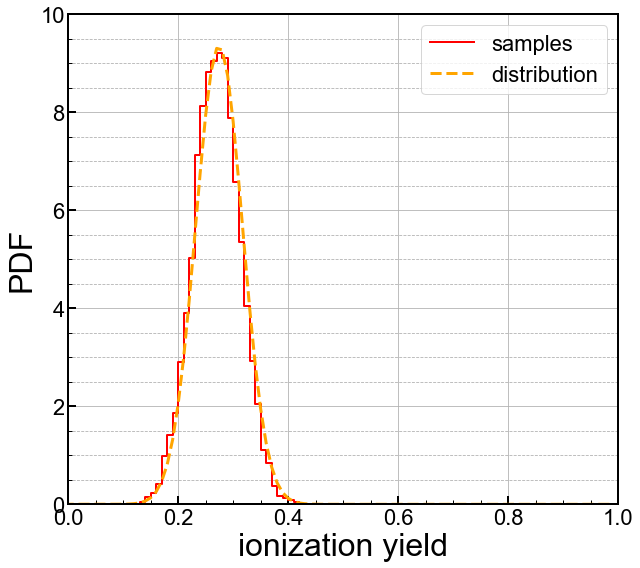

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ax1.step(xc,n/(np.sum(n)*(x[1]-x[0])), where='mid',color='r', linestyle='-', \
         label='samples', linewidth=2)

ax1.plot(x,Qdistv(x),color='orange',linestyle='--',linewidth=3,label='distribution')

ymin = 0
ymax = 10



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 1) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()